In [1]:
# CT사진에서 폐영역만 흰부분으로 처리하여 추출 CT사진에서 폐영역만 흰부분으로 처리하여 추출
# Convolutional Encoder : 차원 축소를 통해 핵심 요소만 뽑는다 (Downsampling-Maxpooling) / Decoder(Upsampling2D) : 압축된 정보로부터 큰차원의 정보를 확인
# 결과는 흑백사진으로 검은색(0) / 흰색(1) : 흰색부분이 폐영역이다다
# Dataset : https://www.kaggle.com/kmader/finding-lungs-in-ct-data

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

In [8]:
# data preprocess 처리를 통해 생성한 파일 로드 data preprocess 처리를 통해 생성한 파일 로드
x_train = np.load('dataset/x_train.npy')
# CT이미지
y_train = np.load('dataset/y_train.npy')
# 폐 영역 마스크 이미지
x_val = np.load('dataset/x_val.npy')
y_val = np.load('dataset/y_val.npy')

print(x_train.shape, y_train.shape)
# (,,,1) : 1채널은 grayscale
print(x_val.shape, y_val.shape)

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


In [21]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)
net = MaxPooling2D(pool_size=2, padding='same')(net)
# 차원을 pool_size만큼 축소

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)

# Maxpooling 개수와 같이 Upsampling으로 차원확정
net = UpSampling2D(size=2)(net)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)
# 1채널의 output(sigomid)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0     

In [26]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_val, y_val), 
                    epochs=100, batch_size=32, 
                    callbacks=[ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2, patience=10, 
                                                 verbose=1, mode='auto', 
                                                 min_lr=1e-05)
])

Epoch 1/100
8/8 [==============================] - 40s 614ms/step - loss: 0.6192 - acc: 0.7309 - mse: 0.2012 - val_loss: 0.5155 - val_acc: 0.7431 - val_mse: 0.1668
Epoch 2/100
8/8 [==============================] - 1s 179ms/step - loss: 0.4923 - acc: 0.7509 - mse: 0.1597 - val_loss: 0.4488 - val_acc: 0.7431 - val_mse: 0.1478
Epoch 3/100
8/8 [==============================] - 1s 179ms/step - loss: 0.4381 - acc: 0.7449 - mse: 0.1442 - val_loss: 0.3766 - val_acc: 0.7578 - val_mse: 0.1236
Epoch 4/100
8/8 [==============================] - 1s 181ms/step - loss: 0.4109 - acc: 0.7490 - mse: 0.1355 - val_loss: 0.4594 - val_acc: 0.7214 - val_mse: 0.1528
Epoch 5/100
8/8 [==============================] - 1s 180ms/step - loss: 0.4287 - acc: 0.7337 - mse: 0.1439 - val_loss: 0.3649 - val_acc: 0.8166 - val_mse: 0.1175
Epoch 6/100
8/8 [==============================] - 1s 182ms/step - loss: 0.3616 - acc: 0.8009 - mse: 0.1173 - val_loss: 0.3085 - val_acc: 0.8268 - val_mse: 0.0974
Epoch 7/100
8/8 [====

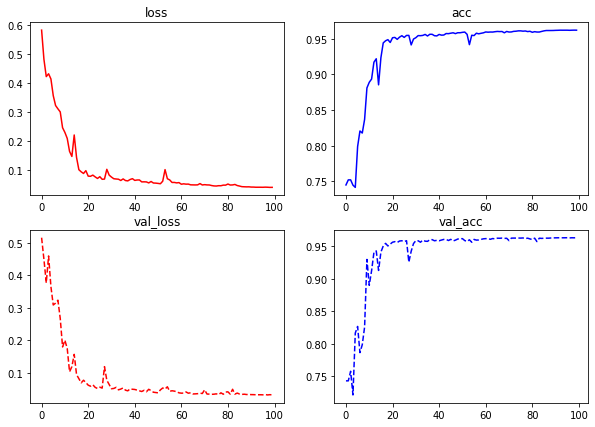

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

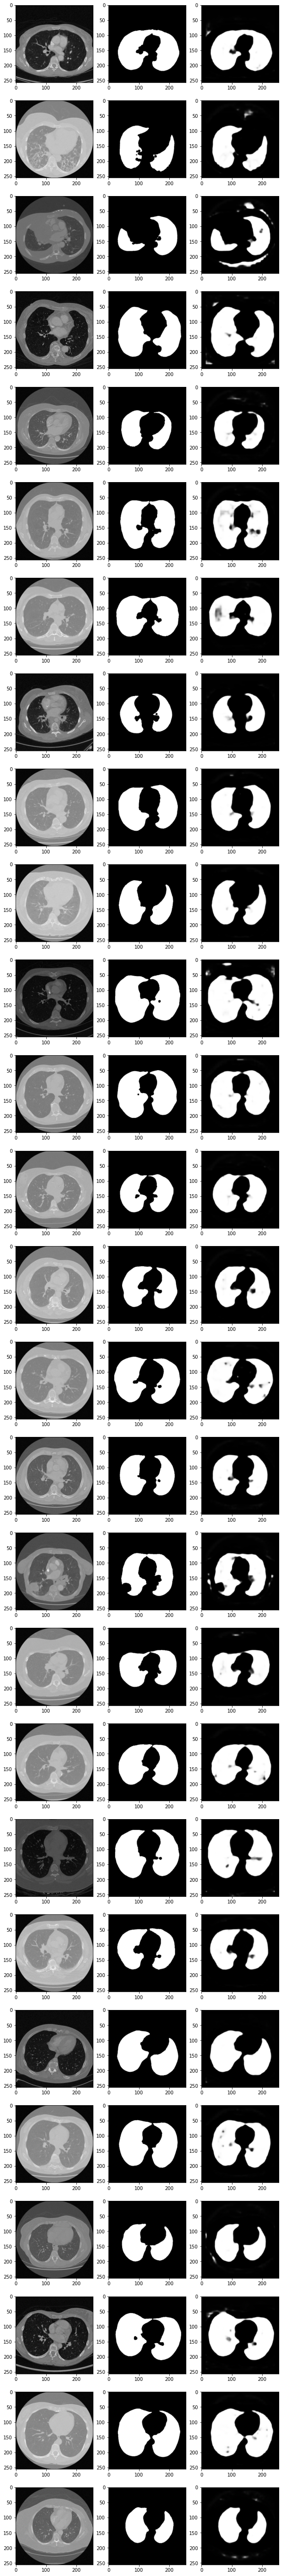

In [34]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray') # CT Data
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray') # 정답
    ax[i, 2].imshow(pred.squeeze(), cmap='gray') # 예측 Data